# Backyard Bird Classifier

## 1. Business Understanding

Project FeederWatch, operated by the Cornell Lab of Ornithology and Birds Canada, is a community science program that encourages individuals across North America to monitor and report bird species visiting their feeders. The project has been running since 1987 and provides a valuable long-term dataset to scientists studying the distribution, abundance, and migration patterns of wintering bird species.

Participants submit bird counts from their homes, nature centers, schools, or community spaces using a flexible schedule between November and April. These data have been used in numerous scientific studies, revealing trends in species ranges, population shifts, and feeder use. However, because observations are made by people of all skill levels—many of them amateur birders—identification errors are common. This introduces noise into the dataset, potentially obscuring long-term trends and biological signals.

To mitigate this limitation, this project proposes a computer vision approach to improve the consistency and accuracy of bird species identification from images. By training a machine learning model to classify feeder birds, we can provide an automated or semi-automated tool to assist human observers and validate their reports.

Cornell’s NABirds dataset contains over 48,000 annotated images of 555 bird species commonly observed in North America. This project will subset that dataset using Cornell’s list of the 100 most common feeder birds and train a deep learning model to recognize them from photographs. The long-term goal is to support systems that can automatically identify feeder birds from camera traps or assist FeederWatch participants in double-checking their own identifications.

### Objective

Build and evaluate an image classification model that can:

- Automatically identify bird species from a curated list of the 100 most common feeder birds
- Achieve greater than 80% overall classification accuracy
- Provide per-class metrics such as precision, recall, and F1-score to assess individual species performance
- Incorporate interpretability tools (e.g., LIME and Grad-CAM) to explain model predictions
- Be exportable to lightweight formats (e.g., ONNX) for deployment on edge devices like the Raspberry Pi

### Data Sources

- NABirds Dataset: [https://dl.allaboutbirds.org/nabirds](https://dl.allaboutbirds.org/nabirds)
- FeederWatch Program: [https://feederwatch.org](https://feederwatch.org)
- 100 Common Feeder Birds: [https://feederwatch.org/learn/common-feeder-birds/](https://feederwatch.org/learn/common-feeder-birds/)

## 2. Data Understanding

#### Dataset Access

This notebook uses a public subset of the NABirds dataset hosted on Kaggle:

**Dataset:** [Backyard Feeder Birds (NABirds Subset)](https://www.kaggle.com/datasets/jakemccaig/backyard-feeder-birds-nabirds-subset)  
**Owner:** [jakemccaig](https://www.kaggle.com/jakemccaig)  
**Structure:** ImageNet-style `train/`, `val/`, and `class_labels.txt`

---

This dataset is a subset of the NABirds dataset filtered to include the 100 most common backyard feeder birds in North America, based on recommendations from the Cornell Lab of Ornithology. It follows an ImageNet-style structure with a `train/` and `val/` folder and a `class_labels.txt` file.

Each subfolder within `train/` and `val/` corresponds to a species label, which may include additional descriptors (e.g., age, sex, plumage). These distinctions enable more detailed recognition, as many feeder birds differ in appearance by season or gender.

---

### Dataset Composition Summary

- Total classes: **134**
- Total training images: **10,562**
- Total validation images: **2,690**
- Total images overall: **13,252**
- Maximum images in a single class: **120**
- Minimum images in a single class: **13**
- Median images per class: **110**
- Mean images per class: **98.90**

The dataset is reasonably balanced, with most classes having over 75 total images. Manual curation helped reduce severe class imbalance, but we will still monitor for underrepresented species during training.

---

### Class Distribution Visualizations

A full bar chart and heatmap visualization confirm that the number of images per species is relatively consistent across both training and validation splits.

---

### Image Sample Inspection

A random set of images were sampled and show birds at various distances, angles, and with various backgrounds, exposures, brightness, and contrasts.

---

### Image Size & Aspect Ratio Summary

- Total images analyzed: **10,562**
- Image widths range from **90 px** to **1024 px**, with a mean of **906.4 px**
- Image heights range from **100 px** to **1024 px**, with a mean of **730.7 px**
- Aspect ratios (width ÷ height) range from **0.45** to **2.39**, with a mean of **1.28**

These statistics indicate that most images are roughly landscape or square in shape, though a small number of outliers exist. Images will be resized to 600×600 during preprocessing to ensure model consistency.

In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
import numpy as np
import tqdm

In [4]:
# Define base paths
base_path = "./backyard_birds_dataset"
train_path = os.path.join(base_path, "train")
val_path = os.path.join(base_path, "val")

# Load class folders
class_names = sorted(os.listdir(train_path))

Dataset Composition Summary:
- Total classes: 134
- Total training images: 10562
- Total validation images: 2690
- Total images overall: 13252
- Max images in a single class: 120
- Min images in a single class: 13
- Median images per class: 110.0
- Mean images per class: 98.90


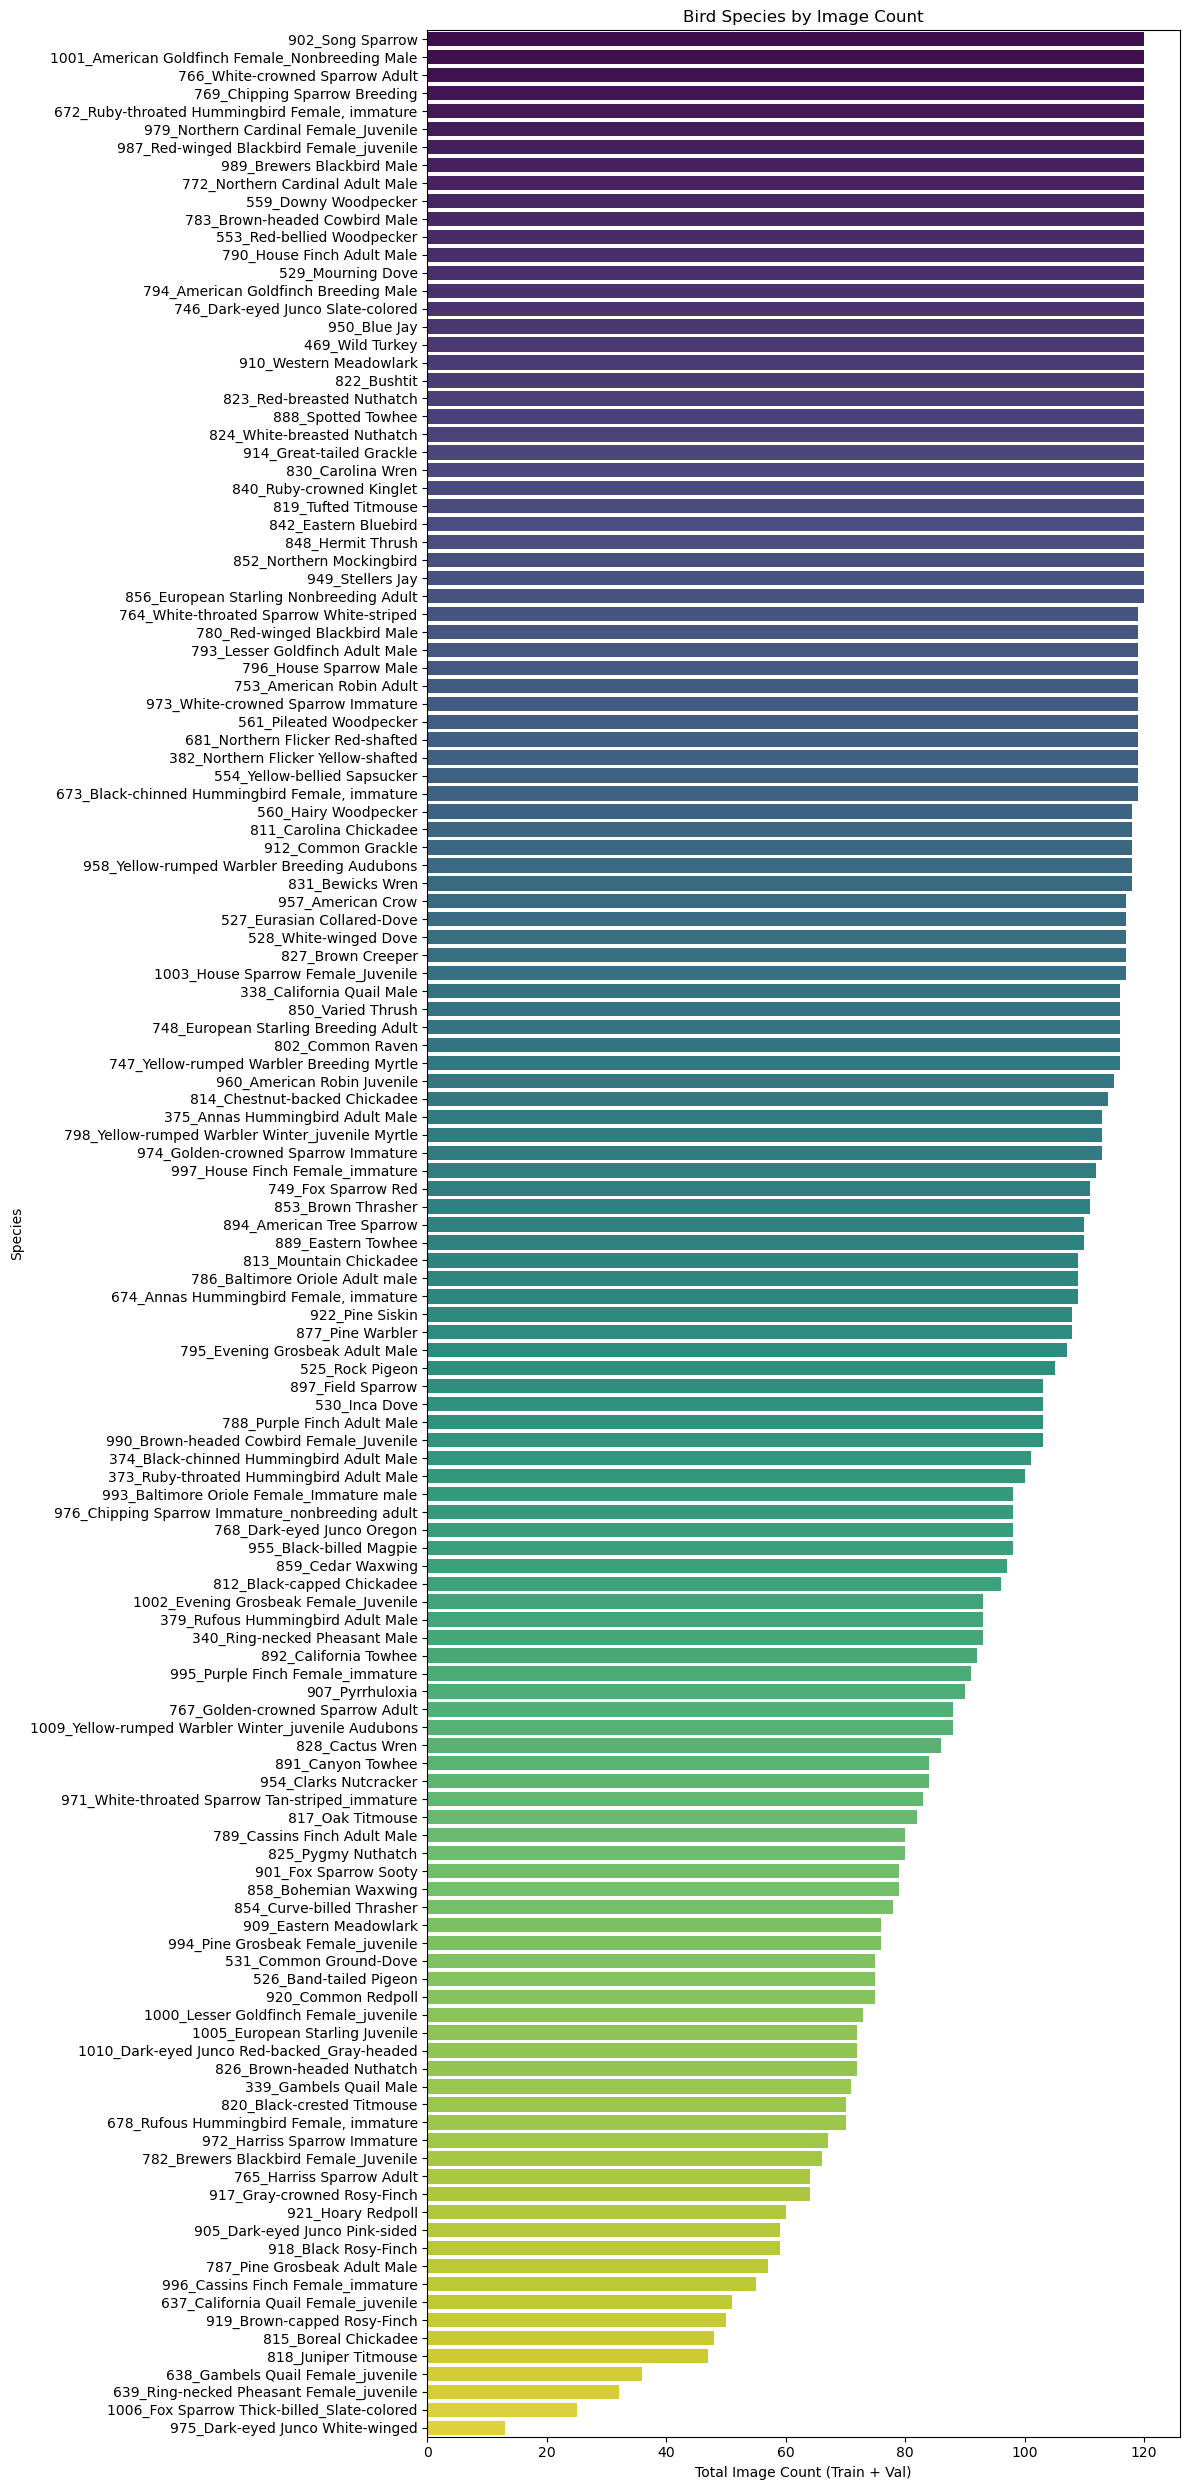

In [25]:
# Visualize image counts per class
class_names = sorted([
    d for d in os.listdir(train_path)
    if os.path.isdir(os.path.join(train_path, d))
])

# Count images per class
train_counts = {cls: len(os.listdir(os.path.join(train_path, cls))) for cls in class_names}
val_counts = {cls: len(os.listdir(os.path.join(val_path, cls))) for cls in class_names}

# Combine into DataFrame
df_counts = pd.DataFrame({
    "Class": class_names,
    "Train Count": [train_counts[cls] for cls in class_names],
    "Val Count": [val_counts[cls] for cls in class_names]
})
df_counts["Total"] = df_counts["Train Count"] + df_counts["Val Count"]
df_counts = df_counts.sort_values("Total", ascending=False)

# Summary output
print("Dataset Composition Summary:")
print(f"- Total classes: {len(class_names)}")
print(f"- Total training images: {sum(df_counts['Train Count'])}")
print(f"- Total validation images: {sum(df_counts['Val Count'])}")
print(f"- Total images overall: {sum(df_counts['Total'])}")
print(f"- Max images in a single class: {df_counts['Total'].max()}")
print(f"- Min images in a single class: {df_counts['Total'].min()}")
print(f"- Median images per class: {df_counts['Total'].median()}")
print(f"- Mean images per class: {df_counts['Total'].mean():.2f}")

# Plot top 134 (all)
plt.figure(figsize=(12, 25))
sns.barplot(
    data=df_counts.head(134),
    x="Total", y="Class", hue="Class", palette="viridis", legend=False
)
plt.title("Bird Species by Image Count")
plt.xlabel("Total Image Count (Train + Val)")
plt.ylabel("Species")
plt.tight_layout()
plt.show()

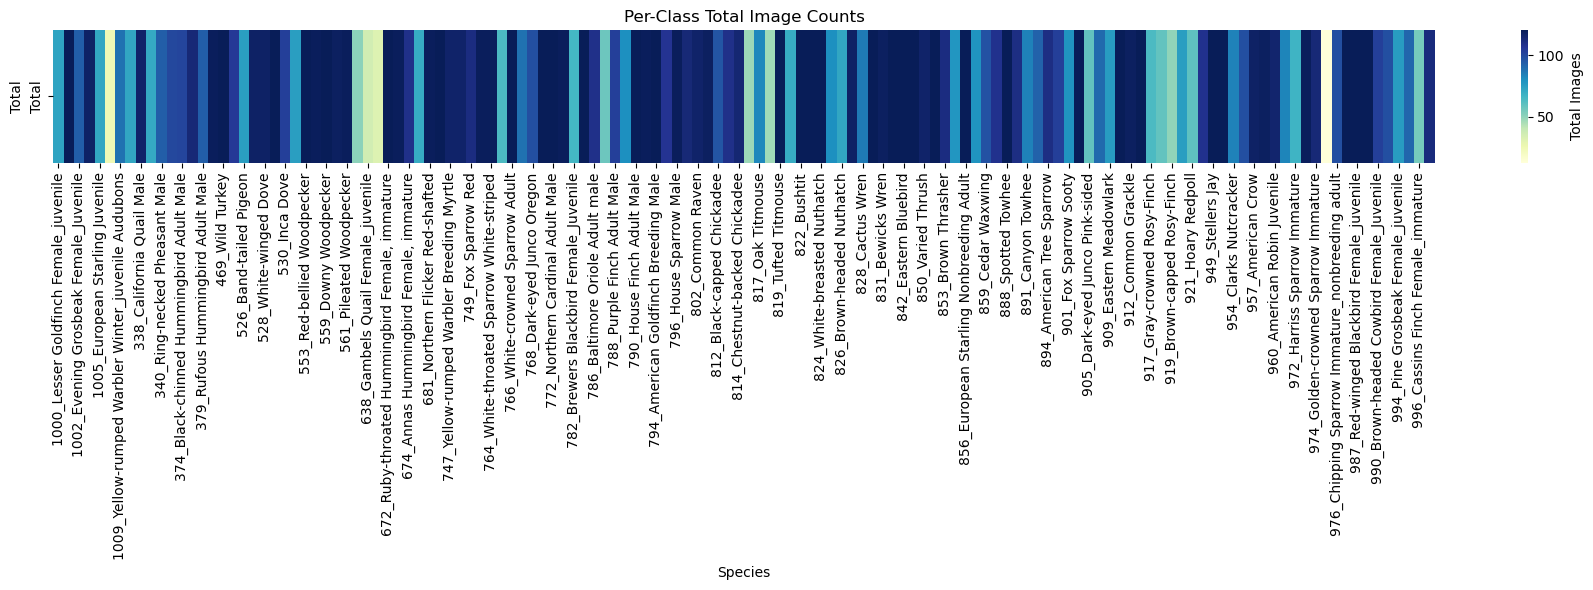

In [29]:
# Sort by class name for consistent layout
df_heatmap_total = df_counts.sort_values("Class").set_index("Class")[["Total"]]

# Transpose for a horizontal layout
plt.figure(figsize=(18, 6))
sns.heatmap(df_heatmap_total.T, cmap="YlGnBu", cbar_kws={'label': 'Total Images'})
plt.title("Per-Class Total Image Counts")
plt.xlabel("Species")
plt.ylabel("Total")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

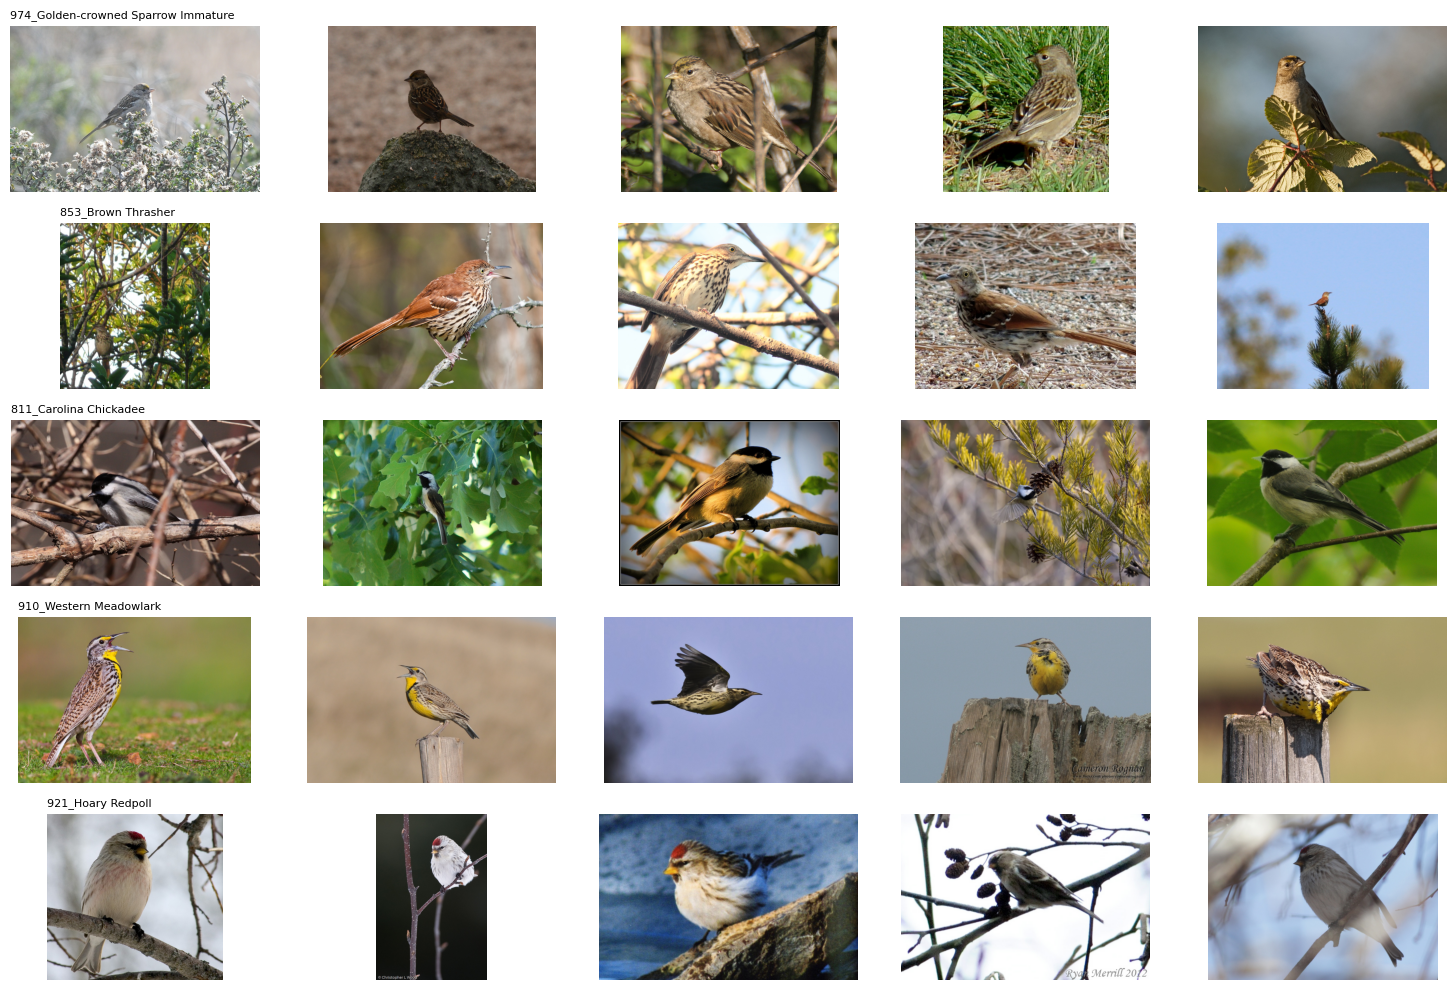

In [21]:
# View a sampling of images
num_classes_to_sample = 5
images_per_class = 5

sampled_classes = random.sample(class_names, num_classes_to_sample)

fig, axes = plt.subplots(num_classes_to_sample, images_per_class, figsize=(15, 10))
for row_idx, cls in enumerate(sampled_classes):
    img_files = os.listdir(os.path.join(train_path, cls))
    img_samples = random.sample(img_files, min(images_per_class, len(img_files)))
    for col_idx, img_file in enumerate(img_samples):
        img_path = os.path.join(train_path, cls, img_file)
        img = Image.open(img_path).convert("RGB")
        axes[row_idx, col_idx].imshow(img)
        axes[row_idx, col_idx].axis("off")
        if col_idx == 0:
            axes[row_idx, col_idx].set_title(cls[:40], fontsize=8, loc="left")
plt.tight_layout()
plt.show()

Image Resolution Statistics (Train Set):
- Total images analyzed: 10562
- Widths: min=90 px | max=1024 px | mean=906.4 px
- Heights: min=100 px | max=1024 px | mean=730.7 px
- Aspect Ratio (W/H): min=0.45 | max=2.39 | mean=1.28


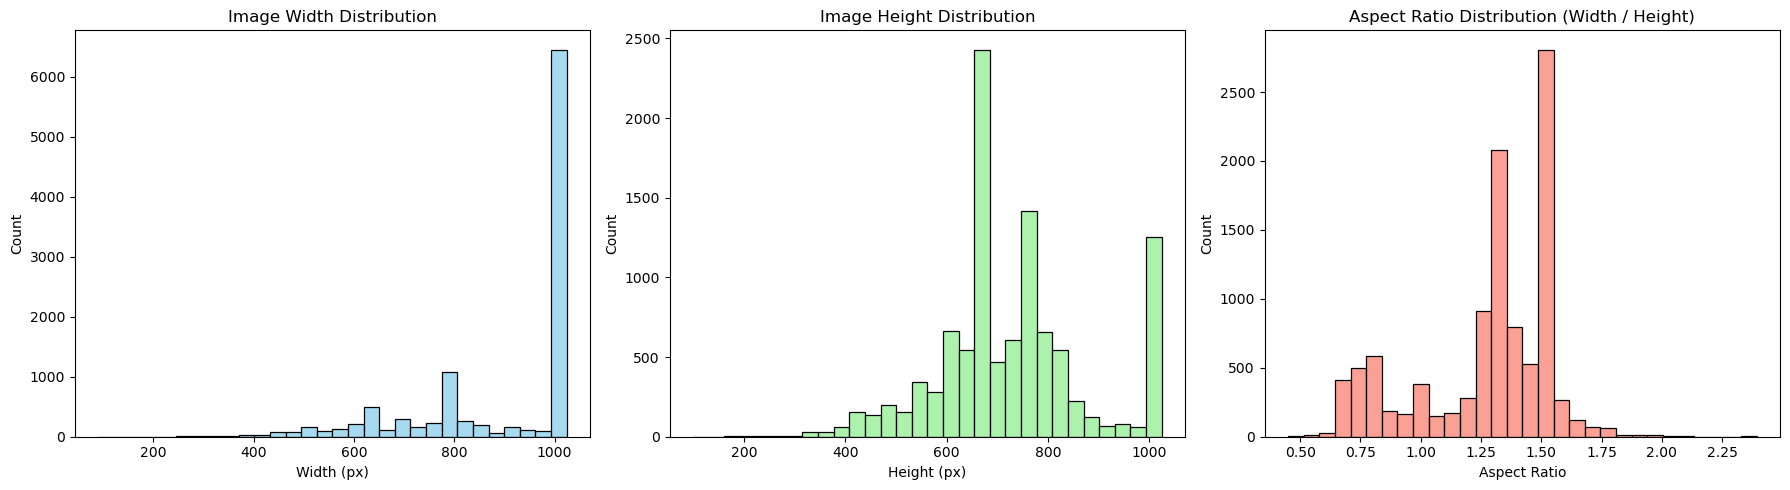

In [24]:
# Visualize image sizes and aspect ratios

# Collect image dimensions
widths, heights, aspect_ratios = [], [], []

for cls in os.listdir(train_path):
    class_dir = os.path.join(train_path, cls)
    if not os.path.isdir(class_dir): continue
    for fname in os.listdir(class_dir):
        fpath = os.path.join(class_dir, fname)
        try:
            with Image.open(fpath) as img:
                w, h = img.size
                widths.append(w)
                heights.append(h)
                aspect_ratios.append(w / h)
        except:
            continue  # skip unreadable images

# Print summary stats
print("Image Resolution Statistics (Train Set):")
print(f"- Total images analyzed: {len(widths)}")
print(f"- Widths: min={np.min(widths)} px | max={np.max(widths)} px | mean={np.mean(widths):.1f} px")
print(f"- Heights: min={np.min(heights)} px | max={np.max(heights)} px | mean={np.mean(heights):.1f} px")
print(f"- Aspect Ratio (W/H): min={np.min(aspect_ratios):.2f} | max={np.max(aspect_ratios):.2f} | mean={np.mean(aspect_ratios):.2f}")

# Plot histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(widths, bins=30, ax=axes[0], color="skyblue")
axes[0].set_title("Image Width Distribution")
axes[0].set_xlabel("Width (px)")

sns.histplot(heights, bins=30, ax=axes[1], color="lightgreen")
axes[1].set_title("Image Height Distribution")
axes[1].set_xlabel("Height (px)")

sns.histplot(aspect_ratios, bins=30, ax=axes[2], color="salmon")
axes[2].set_title("Aspect Ratio Distribution (Width / Height)")
axes[2].set_xlabel("Aspect Ratio")

plt.tight_layout()
plt.show()

### Data Prep/Cleaning

### Modeling

### Evaluation/Interpretability

### Deployment